In [1]:
import os, sys
import numpy as np
from astropy import units, constants
from astropy.io import fits
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize, curve_fit
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks, gaussian
from scipy.interpolate import interp1d
from lmfit import Model
import lmfit
import matplotlib.cm as cm
import matplotlib.animation as animation
from lightkurve.lightcurve import LightCurve


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

## PROPOSAL ID 16164
plt.rcParams['font.size']=18

def load_data(path):
    wavelength, flux, err = load_binned_data(os.path.join(path,'interp_between_1.npy'))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced2')

_, flare_orbits, flare_mask = np.load('/Users/belugawhale/Documents/AUMic/flare_mask2.npy',
                                      allow_pickle=True)

parula = np.load('/Users/belugawhale/parula_colors.npy')

distance = (9.72*units.pc).to(units.cm)


COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

In [2]:
fwc = FlaresWithCOS(wavelength=np.append(w20, w30, axis=0), 
                    flux=np.append(f20, f30, axis=0),
                    flux_err=np.append(e20, e30, axis=0), 
                    time=np.append(t20, t30)-t20[0], 
                    orbit=np.append(o20, o30+5))
fwc.load_line_table(path='/Users/belugawhale/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/belugawhale/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

main_ions = ['CII_11', 'SiIII', 'CIII', 'NV_1', 'NV_2', 'FeXXI']
ion_color = parula[np.linspace(0,200,5,dtype=int)]
quies_color = '#878482'

for i in main_ions:
    fwc.measure_ew(ion=i)
fwc.measure_ew(ion='CII_10')

## Line fitting

CII_10 3


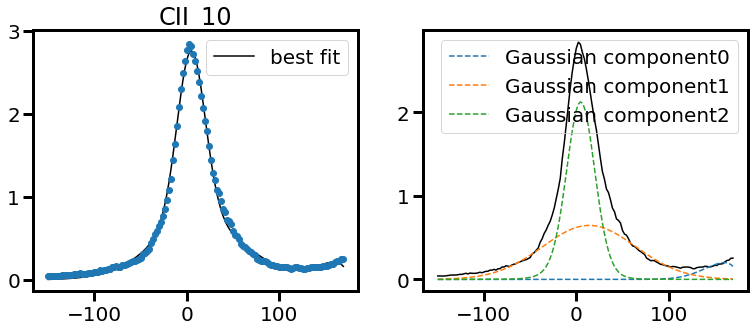

SiIII 3


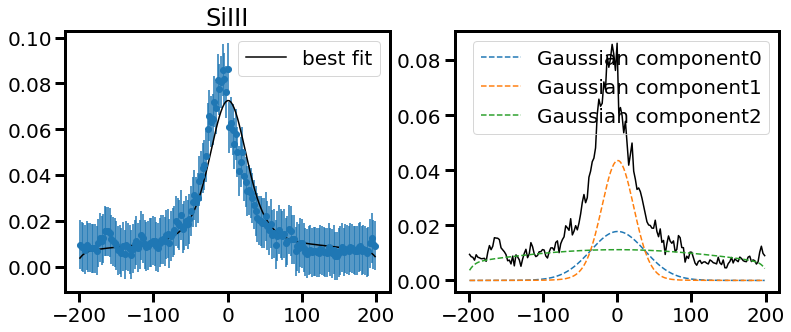

CIII 7


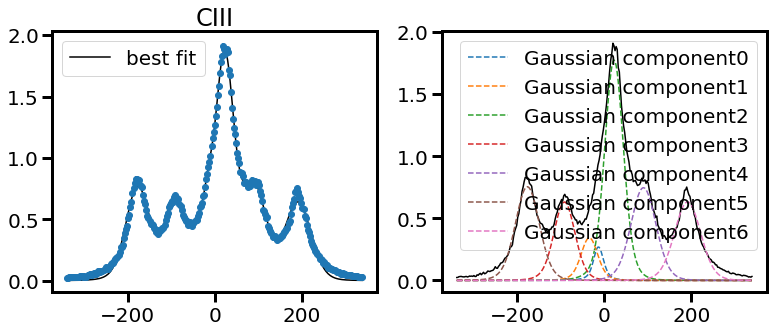

NV_1 2


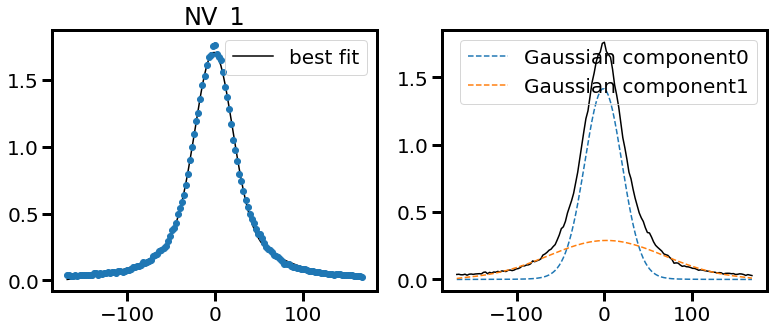

NV_2 2


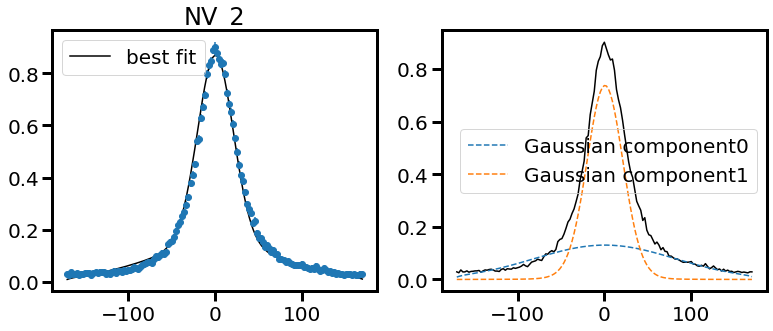

FeXXI 1


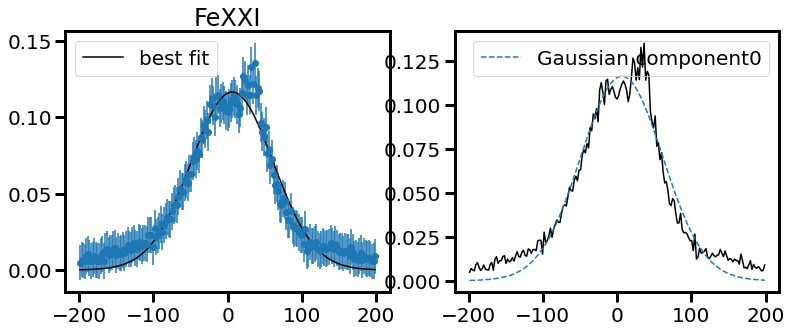

In [11]:
oot = np.nansum(flare_mask, axis=0)==0
scaling = 1e-13

oof_values = []

for i in range(len(main_ions)):
    ngauss = fwc.line_table[fwc.line_table['ion']==main_ions[i]]['ngauss'].data[0]+0
    
    if i == 0 or i == 1:
        ngauss = 3
    #elif i == 1:
    #    ngauss = 3
    elif i == 2:
        ngauss = 7
    elif i == 5:
        ngauss = 1
    else:
        ngauss=2
    print(main_ions[i], ngauss)

    spect = np.nanmean(fwc.flux[oot],axis=0)
    err = np.sqrt(np.nansum(fwc.flux_err[oot]**2,axis=0))/(len(fwc.flux[oot]))*0.5
    
    
    x,y,yerr,w,lsf,out = fwc.model_line_shape(ion=main_ions[i],
                                              mask=oot, 
                                              ngauss=ngauss, 
                                              ext=100,
                                              f=spect/scaling, 
                                              ferr=err/scaling)
    args = [x,y,yerr,w,lsf,out.minimize(max_nfev=3000), out]
    oof_values.append(args)
    
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    
    axes[0].errorbar(x, y, yerr=yerr, marker='o', linestyle='')

    axes[0].plot(args[0], args[-1].best_fit, 'k-', label='best fit')
    axes[0].legend(loc='best')
    axes[0].set_title(main_ions[i])
    comps = args[-1].eval_components(x=args[0])
    
    axes[1].plot(args[0], args[1], 'k')
    for i in range(ngauss):
        axes[1].plot(args[0], 
                     comps['g{}_'.format(i)], '--', label='Gaussian component'+str(i))
    axes[1].legend(loc='best')
    plt.show()

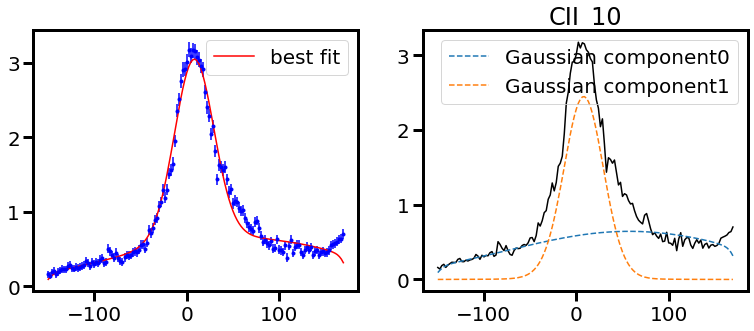

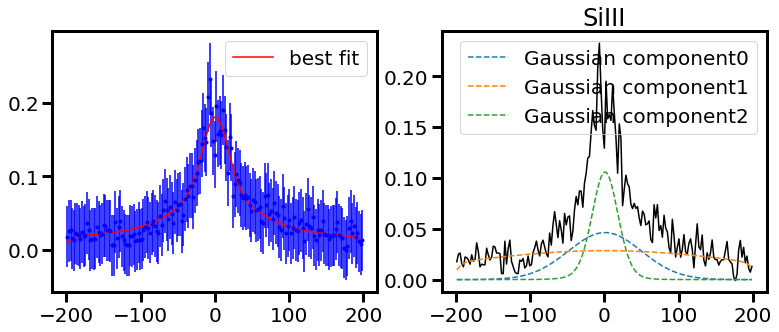

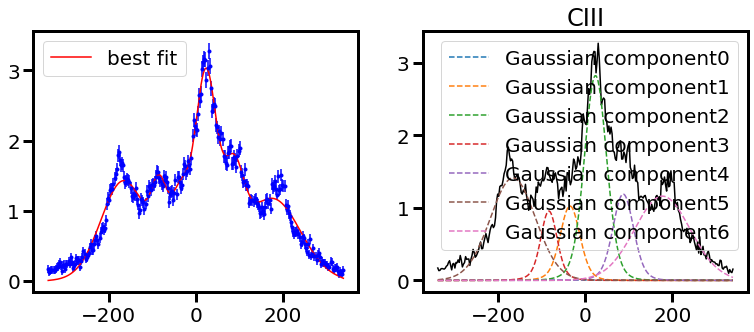

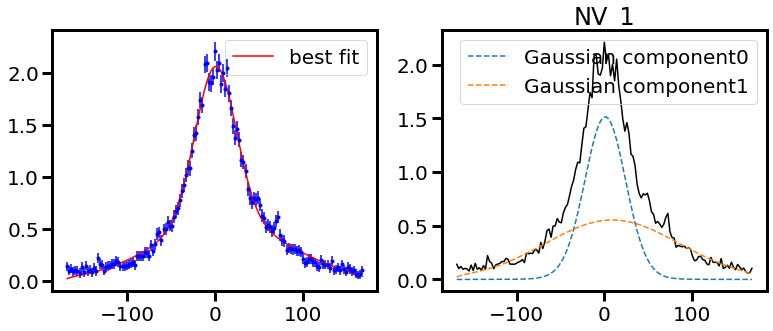

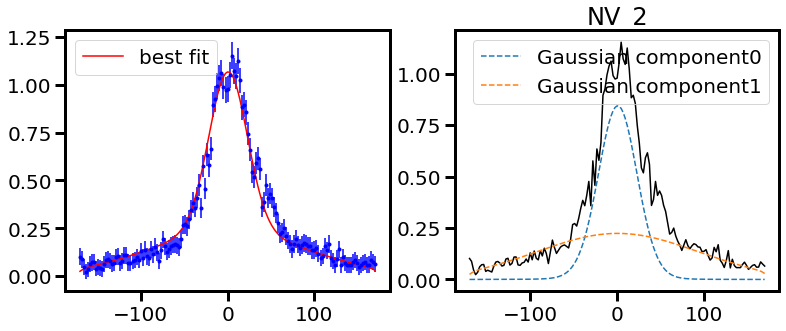

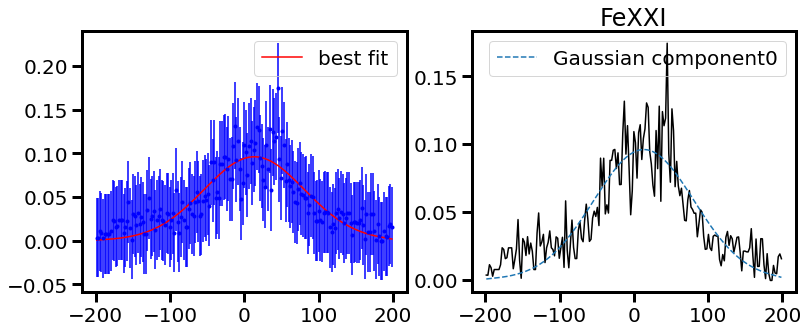

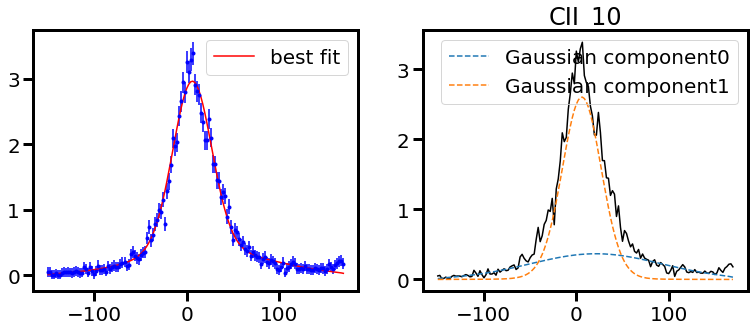

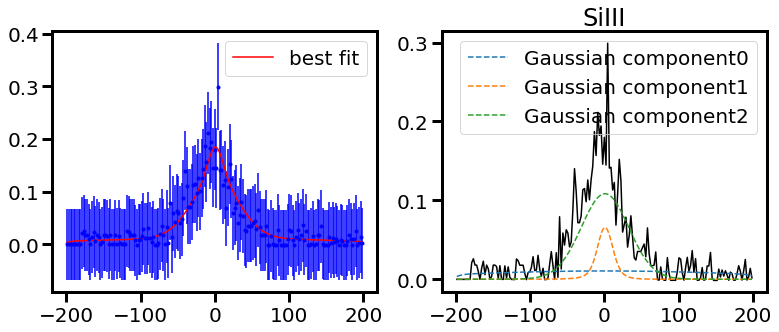

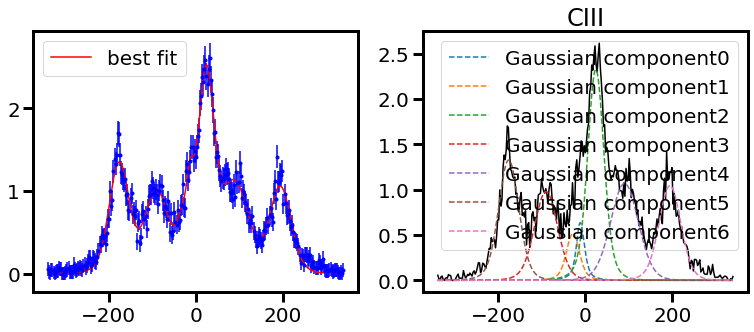

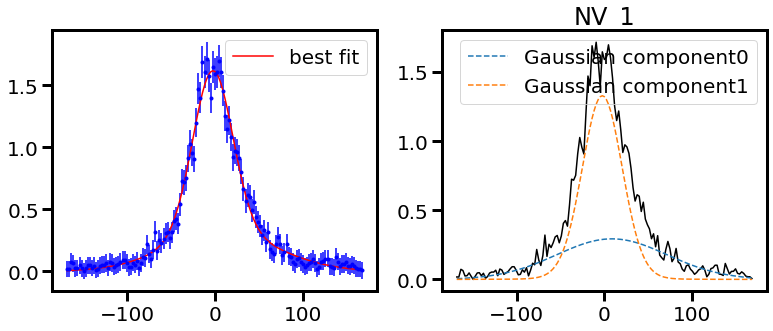

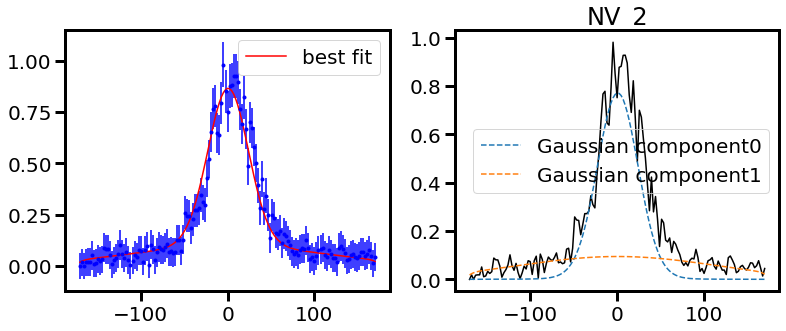

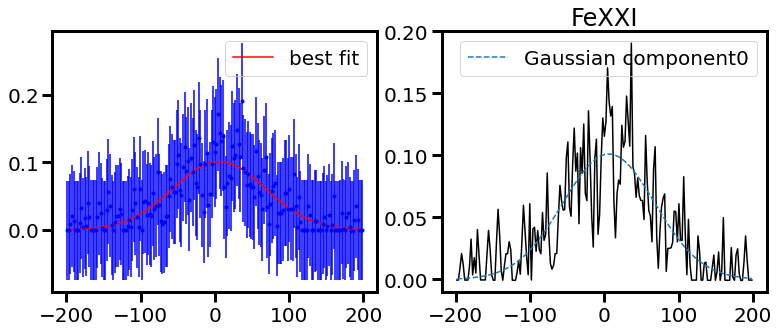

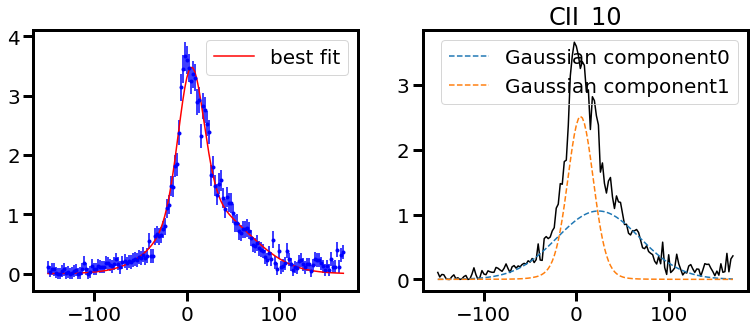

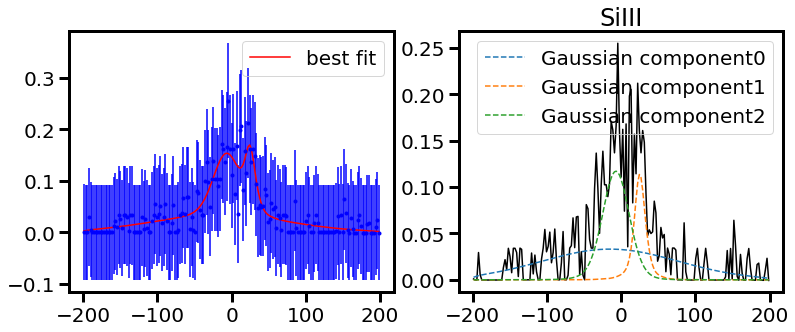

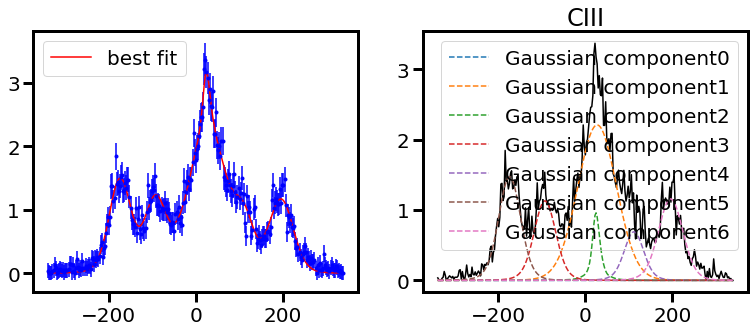

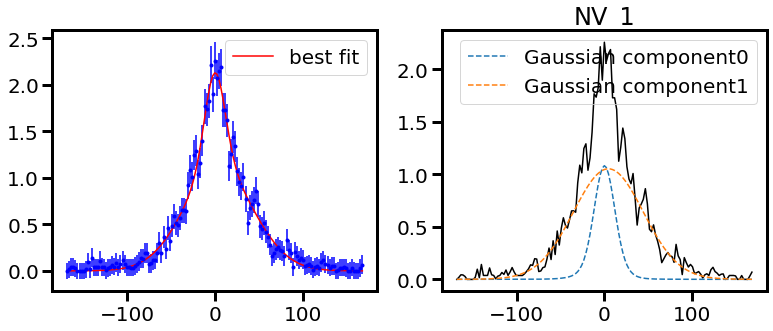

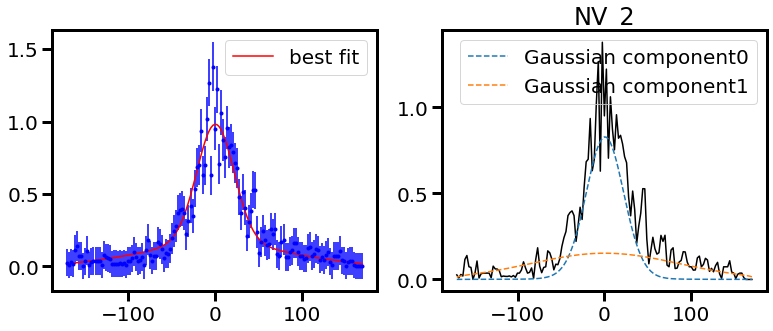

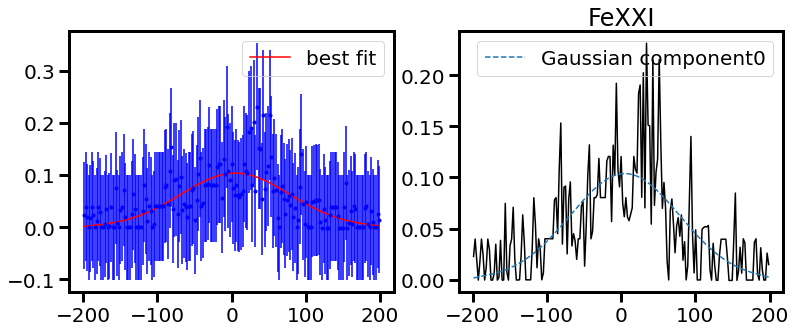

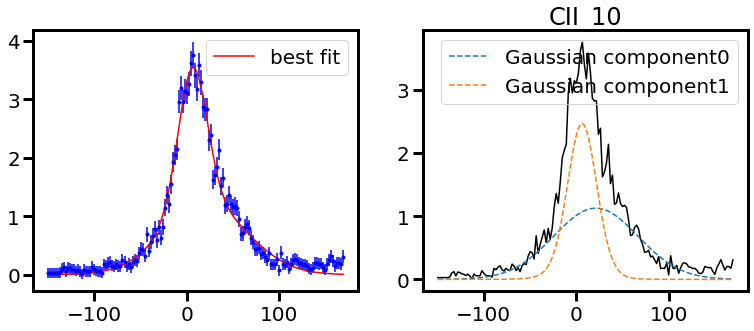

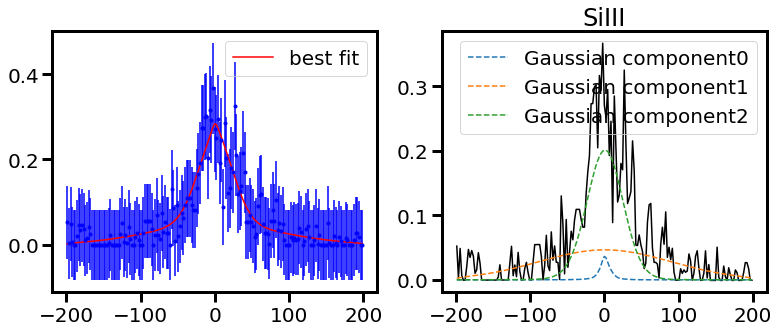

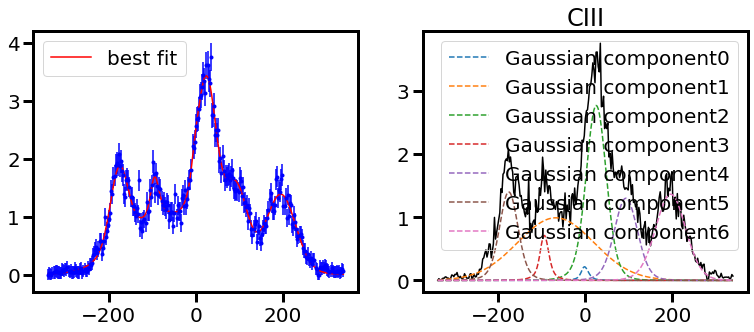

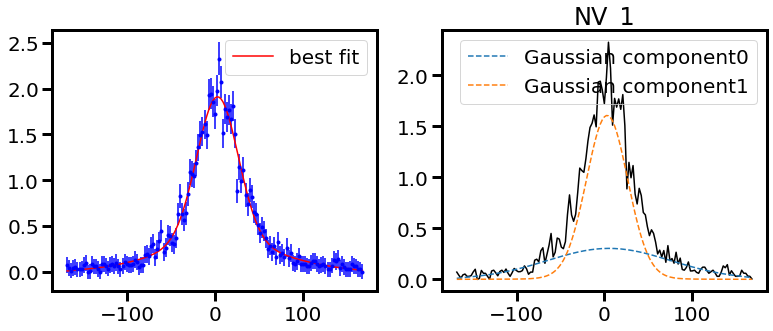

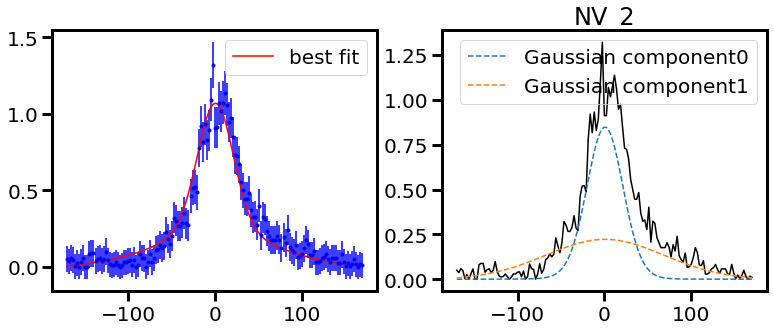

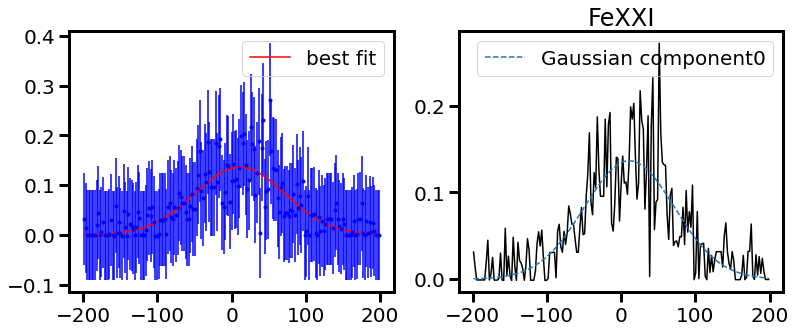

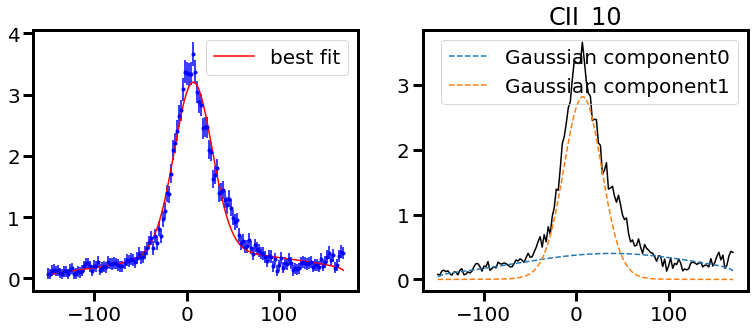

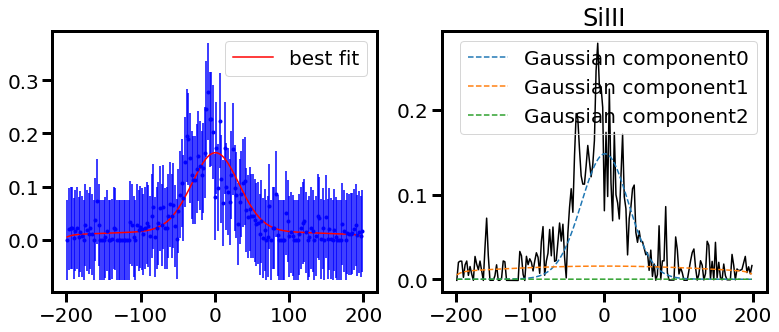

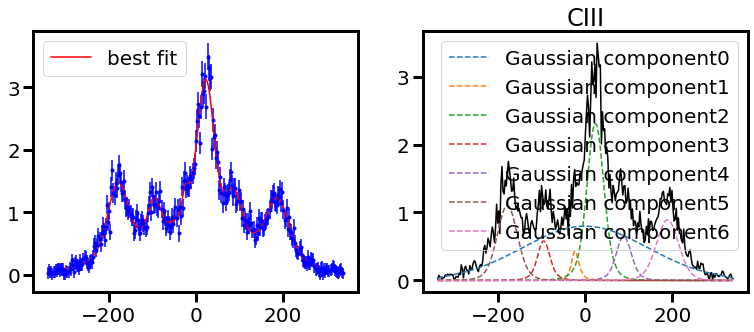

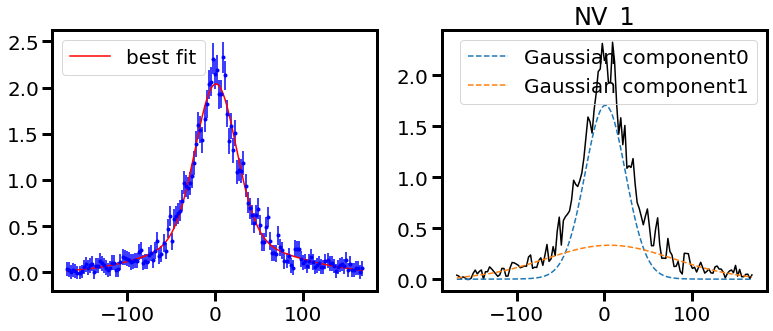

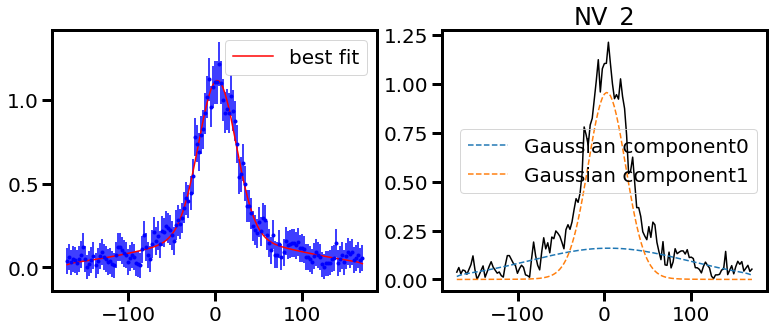

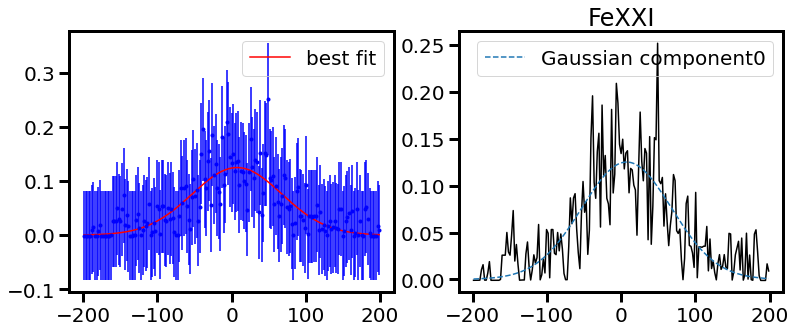

In [8]:
ngauss=4

it_masks = [flare_mask[1]>0,
            flare_mask[3]>0,
            flare_mask[-4]>0,
            flare_mask[-3]>0,
            flare_mask[-1]>0]

if_values = []

main_ions = ['CII_10', 'SiIII', 'CIII', 'NV_1', 'NV_2', 'FeXXI']

for m in it_masks:
    temp = []
    for i in range(len(main_ions)):
        ngauss = fwc.line_table[fwc.line_table['ion']==main_ions[i]]['ngauss'].data[0]+0

        if i == 2:
            ngauss = 7
        elif i==1:
            ngauss=3
        elif i ==5:
            ngauss=1
        else:
            ngauss=2
            
        spect = np.nanmean(fwc.flux[m],axis=0)
        err = np.sqrt(np.nansum(fwc.flux_err[m]**2,axis=0))/(len(fwc.flux[m]))*0.5
    
        x,y,yerr,w,lsf,out = fwc.model_line_shape(ion=main_ions[i],
                                                  mask=m, 
                                                  ngauss=ngauss, 
                                                  ext=100,
                                                  f=spect/scaling, 
                                                  ferr=err/scaling)
        args = [x,y,yerr,w,lsf,out.minimize(max_nfev=3000), out]

        fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
        axes = axes.reshape(-1)
        axes[0].errorbar(args[0], args[1], yerr=args[2], color='b',
                         linestyle='', marker='.')
        #axes[0].plot(vel, init, 'k--', label='initial fit')
        axes[0].plot(args[0], args[-1].best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')

        comps = args[-1].eval_components(x=args[0])
        axes[1].plot(args[0], args[1], 'k')
        for n in range(ngauss):
            axes[1].plot(args[0], comps['g{}_'.format(n)], '--', label='Gaussian component'+str(n))
        axes[1].legend(loc='best')
        axes[1].set_title(main_ions[i])
        plt.show()
        temp.append(args)
    if_values.append(temp)

In [9]:
oof_models = []

for i in range(len(oof_values)):
    res = oof_values[i][-1].minimize(max_nfev=10000, xtol=1e-8)
    oof_models.append(res)
    
if_models = []
for j in range(len(if_values)):
    temp = []
    for i in range(len(if_values[j])):
        res = if_values[j][i][-1].minimize(max_nfev=20000,xtol=1e-8)
        temp.append(res)
    if_models.append(temp)

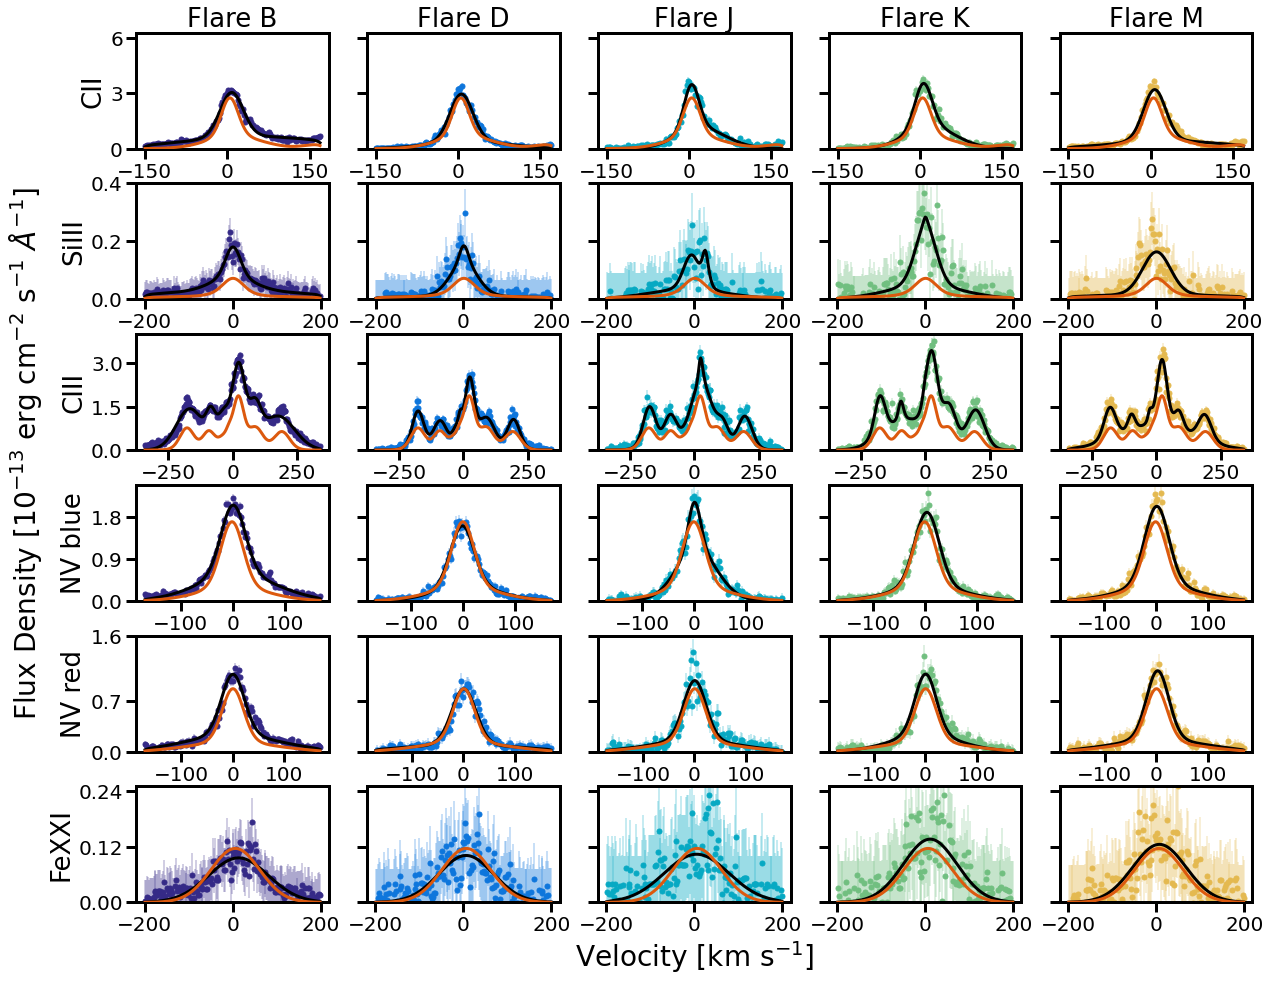

In [12]:
fig, axes = plt.subplots(ncols=5, nrows=6, figsize=(20,16))
fig.set_facecolor('w')
lw = 3
i = 0
ions = ['CII', 'SiIII', 'CIII', 'NV blue', 'NV red', 'FeXXI']
fontsize=26

ax = axes.reshape(-1)
ax_ints = np.arange(0,30,5,dtype=int)
f1 = ax[ax_ints]#:5]
f2 = ax[ax_ints+1]#4:9]
f3 = ax[ax_ints+2]#8:12]
f4 = ax[ax_ints+3]#12:]
f5 = ax[ax_ints+4]

fs = [f1,f2,f3,f4,f5]

for j in range(len(fs)):
    for i in range(len(ions)):
        
        fs[j][i].errorbar(if_values[j][i][0], if_values[j][i][1], 
                          color=ion_color[j], alpha=0.3,
                          ms=1, marker='.', zorder=1,
                          yerr=if_values[j][i][2], linestyle='')
        fs[j][i].errorbar(if_values[j][i][0], if_values[j][i][1], 
                          color=ion_color[j], 
                          ms=10, marker='.', zorder=1,
                          linestyle='')


        oo = build_lmfit(oof_values[i][0], 
                         params=oof_values[i][-2].params,
                         lsf=oof_values[i][4], std=-5)
        fs[j][i].plot(oof_values[i][0], oof_values[i][-1].best_fit,
                      color='#dc590e',lw=3,
                      zorder=3)
            
        fs[j][i].plot(if_values[j][i][0], if_values[j][i][-1].best_fit, color='k', lw=3)
            

        try:
            up = build_lmfit(if_values[j][i][0], 
                                 params=if_models[j][i].params,
                                 lsf=if_values[j][i][4], std=2)
            lo = build_lmfit(if_values[j][i][0], 
                                 params=if_models[j][i].params,
                                 lsf=if_values[j][i][4], std=-1)

        except:
            pass
            
        if j > 0:
            fs[j][i].set_yticklabels([])
        
        if j == 0:# and i ==2:
            fs[j][i].set_ylabel('{}'.format(ions[i]), fontsize=fontsize)
            
        if j == 0 and i == 2:
            str1 = 'Flux Density [10$^{-13}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]'
            fs[j][i].text(s=str1, rotation=90, x=-875, y=-9, fontsize=fontsize+2)
            
        if i == 5 and j == 2:
            fs[j][i].set_xlabel('Velocity [km s$^{-1}$]', fontsize=fontsize+2)
        
        fs[j][i].set_rasterized(True)
        
        if i == 0:
            fs[j][i].set_ylim(0,6.3)
            fs[j][i].set_yticks([0,3,6])
        elif i == 1:
            fs[j][i].set_ylim(0,0.4)
            fs[j][i].set_yticks([0,0.2,0.4])
        elif i == 2:
            fs[j][i].set_ylim(0,4)
            fs[j][i].set_yticks([0,1.5,3])
        elif i == 3:
            fs[j][i].set_ylim(0,2.5)
            fs[j][i].set_yticks([0,0.9, 1.8])
        elif i == 4:
            fs[j][i].set_ylim(0,1.5)
            fs[j][i].set_yticks([0,0.7,1.6])
        else:
            fs[j][i].set_ylim(0,0.25)
            fs[j][i].set_yticks([0,0.12,0.24])
            
        if i == 0:
            fs[j][i].set_xticks([-150,0,150])
            
f1[0].set_title('Flare B', fontsize=fontsize)
f2[0].set_title('Flare D', fontsize=fontsize)
f3[0].set_title('Flare J', fontsize=fontsize)
f4[0].set_title('Flare K', fontsize=fontsize)
f5[0].set_title('Flare M', fontsize=fontsize)
plt.subplots_adjust(hspace=0.3);
#plt.savefig('/Users/belugawhale/Documents/AUMic/paper/linewidths.pdf',
#            dpi=250, rasterize=True, bbox_inches='tight')

In [36]:
letters =['B', 'D', 'J', 'K', 'M']

for i in range(len(ions)):
    for j in range(len(fs)):
        
        
        fs[j][i].errorbar(if_values[j][i][0], if_values[j][i][1], 
                          color=ion_color[j], alpha=0.3,
                          ms=1, marker='.', zorder=1,
                          yerr=if_values[j][i][2], linestyle='')
        fs[j][i].errorbar(if_values[j][i][0], if_values[j][i][1], 
                          color=ion_color[j], 
                          ms=10, marker='.', zorder=1,
                          linestyle='')


        oo = build_lmfit(oof_values[i][0], 
                         params=oof_values[i][-2].params,
                         lsf=oof_values[i][4], std=-5)
        fs[j][i].plot(oof_values[i][0], oof_values[i][-1].best_fit,
                      color='#dc590e',lw=3,
                      zorder=3)
            
        fs[j][i].plot(if_values[j][i][0], if_values[j][i][-1].best_fit, color='k', lw=3)
            
        fwhm_in = np.nanmax(if_values[j][i][-1].best_fit)
        fwhm_out= np.nanmax(oof_values[i][-1].best_fit)
        print(letters[j], ions[i], (fwhm_in-fwhm_out)/fwhm_out*100)
    print('----------')

B CII 10.624506090640129
D CII 7.4396789505212615
J CII 26.078834493552254
K CII 28.51556453128673
M CII 16.238558609713937
----------
B SiIII 149.1449524406688
D SiIII 154.79669209115917
J SiIII 133.78392674644616
K SiIII 291.46158744925424
M SiIII 125.92695342591374
----------
B CIII 61.56335652135406
D CIII 34.83305432520996
J CIII 69.52988301157485
K CIII 83.1759043940491
M CIII 66.75631999475674
----------
B NV blue 21.025271423987682
D NV blue -5.085644562158805
J NV blue 24.813981608572693
K NV blue 11.929827477431635
M NV blue 19.5375214338386
----------
B NV red 22.887268767629944
D NV red -0.3621077494065017
J NV red 12.956524081445242
K NV red 23.19547437181694
M NV red 28.507511619486518
----------
B FeXXI -17.550104985585687
D FeXXI -13.069483347981366
J FeXXI -10.799374536310728
K FeXXI 17.189819026829355
M FeXXI 7.507411705384441
----------
